In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 11 (Monday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Michael Steinbach <stei0062@umn.edu>, Nico Adams adams900@umn.edu

with contributions totally ripped off from Gautham Narayan (UIUC)

## Supervised Learning 

# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning

## Recap


- Unsupervised Learning was about finding structure in the data
    - metric defines the distance between samples
    - useful for clustering, density estimation, anomaly detection
        - **all of these are effectively trying to get at classification**
    
- In Supervised Learning you've got labels for the data
    - metric defines the distance between predictions for the labels and true labels
    - This looks a lot like the first half of the semester, where you wrote down a likelihood function which defined the distance between predictions and truth 

- Just as with GPs we don't write down a model to predict the labels (y) given the features (x) explicitly
    - note that this model is however implicit for some methods
    - the goal in supervised learning is **condition/train** the usually **non-parametric model**

<img src="figures/classification_workflow.jpg">

Individual classifiers are often **weak** (prone to bias/overfitting) so we use **ensembles of classifiers**
- bagging (train classifiers in parallel, ensemble votes on output) 
- boosting (train classifiers in series, each one learning from the mistakes of the previous one, last classifier votes)

(e.g. decision tree vs random forest)

#### The stats viewpoint
- Rather than rely solely on the structure in the data as in unsupervised learning, we're introducing extra information (**priors**) to help improve our ability to model unlabelled data (**prediction**) 

## Performance Measures/Scores (often, also called metrics, just to be confusing):


The first question that we need to address is how we score our results - i.e. how good are our predictions

In the simplest case, there are 2 types of errors:
* a [False Positive](https://en.wikipedia.org/wiki/False_positives_and_false_negatives#False_positive_error), where we have assigned a *true* class label when it is really false. 

This is called a "Type-1 error".

* a [False Negative](https://en.wikipedia.org/wiki/False_positives_and_false_negatives#False_positive_error), where we have assigned a *false* class label when it is really true. 

This is called a "Type-II error".

All 4 [possibilities](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for each pair of classes:
- True Positive = **correctly identified**  (apple identified as apple)
- True Negative = **correctly rejected**  (orange rejected as orange)
- False Positive = **incorrectly identified**  (orange identified as apple)
- False Negative = **incorrectly rejected**  (apple rejected as orange)

In the case where there are only two classes (i.e. binary classification), these are clearly related, but in the multi-class case, these numbers tell you a more complex story:

## The Confusion Matrix

Summarizes the "confusion" for the classifier. 

- For a perfect classifier all of the power will be along the diagonal, while confusion is represented by off-diagonal signal. 

Like almost everything else we have encountered during this exercise, `scikit-learn` makes it easy to compute a confusion matrix. This can be accomplished with the following: 

```
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
```


Here's an example from the <a href="https://www.kaggle.com/c/PLAsTiCC-2018">Photometric LSST Astronomical Time-Series Classificiation Challenge (PLaSTiCC)</a> from the winning entry by then grad student, Kyle Boone:
<img src="figures/KyleBoone_CM.png" width="70%">


You can read about Kyle's winning entry here: https://arxiv.org/abs/1907.04690 (note that you've seen many of the classes in this CM during this semester, either on homework or in-class exercises)

Based on TP/FP/TN/FN, we usually define either of the following pairs of terms:  

>$ {\rm completeness} = \frac{\rm true\ positives}{\rm true\ positives + false\ negatives}$

>$  {\rm contamination} = \frac{\rm false\ positives}{\rm true\ positives + false\ positives} = {\rm false\ discovery\ rate}$

or

> $ {\rm true\ positive\ rate} = \frac{\rm true\ positives} {\rm true\ positives + false\ negatives}
$

> $  {\rm false\ positive\ rate} = \frac{\rm false\ positives} {\rm true\ negatives + false\ positives} = {\rm Type1\ error}
$

where **completeness** = **true positive rate** and this is also called **sensitivity** or **recall**


Which set is used is largely arbitrary and dependent on field/sub-field, but they're largely giving you similar information

Similarly 
 
>$ {\rm efficiency} = 1 - {\rm contamination} = {\rm precision}. $

Scikit-Learn also reports the **F1 score** which is the harmonic mean (i.e. reciprocal of arithmetic mean of reciprocals) of precision and sensitivity (efficiency and completeness).

Depending on your goals, you may want to maximize the completeness or the efficiency, or a combination of both.

## Classifier performance can also be viewed as a tradeoff 

You might want to minimize voter fraud (contamination), but if doing so reduced voter participation (completeness) by a larger amount, then that wouldn't be such a good thing.  

So you need to decide what balance you want to strike.

**Note that this tradeoff is different from the bias/variance tradeoff.** 
You can still infer bias results from a sample without much contamination!

If your labels were positives = detected, and negatives = below detection threshold, you can make the analogy to HW8, where you looked at completeness and efficiency for a simulated survey - what fraction of sources you recovered, and how efficient you were at discriminating sources from background noise excursion. 

You had a hard cut in number of counts (a threshold) so you had a sample that was not contaminated, but if you only used the detected objects for inference you'd still get a biased value for population parameters (exponent of the power law)

## Comparing the performance of classifiers

So, "best" performance is a bit of a subjective topic. 
- We trade contamination as a function of completeness and this is science dependent.

This is true even for just a single classifier, if we get a score (or probability) for an object being a certain class. Then we don't have a sharp decision boundary but rather a threshold that we can vary.

This choice of threshold impacts the TPR/FPR so we want to characterize how it impacts classification. The way that we will do this is with a [**Receiver Operating Characteristic (ROC)**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.  

A ROC curve simply plots the true-positive vs. the false-positive rate as a function of threshold.

## ROC curves 

<table>
    <tr>
        <td width="500px">
            <img src="figures/roc_schematic.jpg">
        </td>
        <td width="500px">
            <img src="figures/roc_plasticc.jpg">
        </td>
     </tr>
</table>

Annoyingly, they're only well defined for binary classification, so if you have a multi-class problem, then you have to:

- plot 1 ROC curve per class
- **micro-averaging**: Reduce multi-class problem to correctly classififed/not-correctly classified regardless of class
- **macro-averaging**: plot average ROC curve across all classes (what's on the right)

## AUC

Generally speaking, you want to chose a classifier that maximizes the **area under the curve.**
- very literally the area under the ROC curve
- classifiers with a higher AUC are better (more true positives, less false positives)

## Precision-Recall curves

You can also plot completeness/contamination or precision/recall.

One concern about precision-Recall curves is that they are sensitive to the relative sample sizes.
- If there are many more background events than source events small false positive results can dominate a signal. 
- For these cases we can plot efficiency (1 - contamination) vs. completeness.

<img src="figures/PRC_turbo_3_downsampled_thresh_lines.png">

## Actually computing performance scores:

- [sklearn.metrics.roc_curve(y_test, y_prob)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.precision_recall_curve(y_test, y_prob)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)
- astroML.utils.completeness_contamination(y_pred, y_test)

**Note** 
- [`sklearn.metrics` algorithms](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) take `y_test`, which are classes, and `y_prob`, which are not class predictions, but rather probabilities
- the AstroML algorithm wants `y_pred` (which we get by converting `y_prob` into discrete predictions as a function of the probability).


## Different Supervised Learning methods:


With Unsupervised Learning, there were a few different approaches-
- centroid-based (k-means/median)
- distribution-based (GMMs/Extreme Deconvolution)
- linkage/connectivity-based (hierarchical clustering/isolation forests)
- density-based (KDEs/DBSCAN/Optics)

We can divide these methods into two groups-

## Generative vs. Discriminative Classification

As an example, if you are trying to determine whether a galaxy is at redshift 0.2 or redshift 2, you could either 
- learn how galaxies are distributed over all redshifts and given this model, you can evaluate the likelihood ratio of the data at both redshifts
- OR, you can learn what key features discriminate between galaxies at z=0.2 and z=2

For example, in the figure below, to classify a new object with $x=1$, it would suffice to know that either 
1) model 1 is a better fit than model 2
or 
2) $x=1.4$ is a good discriminator between the two populations 

![Ivezic, Figure 9.1](http://www.astroml.org/_images/fig_bayes_DB_1.png)

If we find ourselves asking which category is most likely to generate the observed result, then we are using using **density estimation** for classification 
- this is referred to as **generative classification**.  
- we have a full model of the density for each class or we have a model which describes how data could be generated from each class
- both distribution-based (where you assume a form the density) and density-based (where you directly estimate the density from the data) approaches are here

If we don't care about the full distribution, then we are doing something more like clustering
- we don't need to map the distribution, we just need to define boundaries.  
- Classification that finds the **decision boundary** that separates classes is called **discriminative classification**
- centroid-based and linkage-based methods come under this class
- For high-dimensional data, this may be a better choice
    - usual reason - curse of dimensionality
    
You've already seen **decision trees** and **random forests** as examples of discriminative classification

![Ivezic, Figure 9.1](http://www.astroml.org/_images/fig_bayes_DB_1.png)

In reality, we usually do both. 

We first do discriminative classification using a decision boundary based-method, and then we do generative classification using density estimation for the class of interest (in order to determine a probability of group membership).

## Generative Classification

We can use Bayes' theorem to relate the labels to the features in an $N\times D$ data set $X$.  

The $j$th feature of the $i$th sample is $x_{ij}$ and there are $k$ classes giving discrete labels $y_k$.  
Then we have:

$$p(y_k|x_i) = \frac{p(x_i|y_k)p(y_k)}{\sum_i p(x_i|y_k)p(y_k)}$$

where $x_i$ is a vector with $j$ components.

$p(y=y_k)$ is the probability of any point having class $k$ (equivalent to the prior probability of the class $k$). 

In generative classifiers we model class-conditional densities $p_k(x) = p(x|y=y_k)$ and our goal is to estimate the $p_k$'s. 

Before we get into the generative classification algortithms, we'll first discuss 3 general concepts:
- Discriminant Functions
- Bayes Classifiers
- Decision Boundaries

### The Discriminant Function

We can relate classification to density estimation and regression.

$\hat{y} = f(y|x)$ represents the best guess of $y$ given $x$. 

Classification can be thought of as the analog of regression where $y$ is a discrete *category* rather than a continuous variable, for example $y=\{0,1\}$.

(Alternately regression is just classification with very many classes distrbuted on a real number line).

In classification we refer to $f(y|x)$ as the [**discriminant function**](https://en.wikipedia.org/wiki/Discriminant_function_analysis).

For a simple 2-class example, if you want the best guess of the label y:

$$\begin{eqnarray}
g(x) = f(y|x) & = &  \int y \, p(y|x) \, dy \\
%    & = & \int y p(y|x) \, dy \\
       & = & 1 \cdot p(y=1 | x) + 0 \cdot p(y=0 | x) = p(y=1 | x).
%     & = & p(y=1 | x)
\end{eqnarray}
$$

From Bayes rule (yet again):

$$g(x) = \frac{p(x|y=1) \, p(y=1)}{p(x|y=1) \, p(y=1)  + p(x|y=0) \, p(y=0)}$$

### Bayes Classifier

If the discriminant function gives a binary prediction, we call it a **Bayes classifier**, formulated as


$$\begin{eqnarray} \widehat{y} & = & \left\{ \begin{array}{cl}       	           1 & \mbox{if $g(x) > 1/2$}, \\       	           0 & \mbox{otherwise,}       	           \end{array}     	   \right. \\     & = & \left\{
\begin{array}{cl}               1 & \mbox{if $p(y=1|x) > p(y=0|x)$}, \\               0 & \mbox{otherwise.}               \end{array}       \right.\end{eqnarray}$$

**i.e. the best guess class is the most likely** (duh)

This can be generalized to any number of classes, $k$, and not just two.

### Decision Boundary

The **decision boundary** is just the set of $x$ values at which each class is equally likely:

$$
p(x|y=1)p(y=1)  =  p(x|y=0)p(y=0);
$$

$$g_1(x) = g_2(x) \; {\rm or}\; g(x) = 1/2$$

So same figure as earlier - we're just assigning classifications according to which pdf is higher at every given $x$.

![Ivezic, Figure 9.1](http://www.astroml.org/_images/fig_bayes_DB_1.png)


## Simplest Classifier: Naive Bayes

In practice classification can be very complicated as the data are generally multi-dimensional (that is we don't just have $x$, we have $x_{j=0},x_1,x_2,x_3...x_n$, so we want $p(x_0,x_1,x_2,x_3...x_n|y)$.

However, if we **assume** that all attributes are conditionally independent (which is not always true, but is often close enough), then this simplifies to

$$ p(x_1,x_2|y_k) = p(x_1|y)p(x_2|y_k)$$
  
which can be written as

$$ p({x_{j=0},x_1,x_2,\ldots,x_N}|y_k) = \prod_j p(x_j|y_k).$$

From Bayes' rule and conditional independence we get

$$
  p(y_k | {x_0,x_1,\ldots,x_N}) =
  \frac{\prod_j p(x_j|y_k) p(y_k)}
       {\sum_l \prod_j p(x_j|y_l) p(y_l)}.
$$


We calculate the most likely value of $y$ by maximizing over $y_k$:

$$
\hat{y} = \arg \max_{y_k} \frac{\prod_j p(x_j|y_k) p(y_k)}
        {\sum_l \prod_j p(x_j|y_l) p(y_l)},
$$



From there the process is just estimating densities: $p(x|y=y_k)$ and $p(y=y_k)$ are learned from a set of training data, where
- $p(y=y_k)$ is just the frequency of the class $k$ in the training set
- $p(x|y=y_k)$ is just the density (probability) of an object with class $k$ having the attributes $x$


## Gaussian Naive Bayes


Of course, to get $p(x|y=y_k)$ you can use all of the density estimation methods from last week. 

The parametric model is to assert that we have a bunch of 1-D Gaussians i.e. $p(x_i|y=y_k)$ is a normal distributions, with means $\mu_{ik}$ and widths $\sigma_{ik}$. 

The naive Bayes estimator is then

$$\hat{y} = \arg\max_{y_k}\left[\ln p(y=y_k) - \frac{1}{2}\sum_{i=1}^N\left(2\pi(\sigma_{ik})^2 + \frac{(x_i - \mu_{ik})^2}{(\sigma_{ik})^2} \right) \right]$$

The "naive" refers to the fact that we are assuming that all of the variable are independent. You can of course compute the covariance matrix to estimate the degree to which this is bullshit.

But then you can use dimensionality reduction like PCA to help "whiten" the features and construct independent variables.

Generally, naieve Bayes by itself is a bad idea because of the covariances, but PCA might also be a bad idea because it's a linear transformation and the covariance may not be linear.

If instead, we relax that assumption and allow for covariances then:

## Linear Discriminant Analysis

In [Linear Discriminant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) we assume that the class distributions have identical covariances for all $k$ classes (all classes are a set of shifted Gaussians). 

The class-dependent covariances that would normally give rise to a quadratic dependence on
$X$ cancel out if they are assumed to be constant. 

The Bayes classifier is, therefore, linear with respect to $X$, and  discriminant boundary between classes is the line that minimizes the overlap between Gaussians.

Basically, we're projecting N-dimensional data onto k new axes and finding what the optimal decision boundary is for each. Therefore LDA is also used for dimensionality reduction, but the new features may still be correlated.

<img src="figures/lda.png">

Relaxing the requirement that the covariances of the Gaussians are constant, the discriminant function becomes quadratic in $X$.

This is sometimes known as [Quadratic Discriminant Analysis (QDA)](https://en.wikipedia.org/wiki/Quadratic_classifier#Quadratic_discriminant_analysis).

[`LDA`](http://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html) and [`QDA`](http://scikit-learn.org/0.16/modules/generated/sklearn.qda.QDA.html#sklearn.qda.QDA) are implemented in Scikit-Learn as follows and an example using the same data as above is given below.

<img src="figures/lda_vs_qda.png">

## K-Nearest Neighbor Classifier

These approaches are using a model for the population density. We can, just as in unsupervised learning, use linkage instead (or local density):

[$k$-nearest-neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) ($k$NN) is simple and can be used for clasification and regression. 

The output is determined by examining the $k$ nearest neighbors in the training set, where $k$ is a user defined number. 

Typically, though not always, distances between sources are Euclidean, and the final classification is assigned to whichever class has a plurality within the $k$ nearest neighbors (in the case of regression, the average of the $k$ neighbors is the output from the model). 

The number of neighbors, $k$, regulates the complexity of the classification, where a larger $K$ decreases the variance in the classification but leads to an increase in the bias.  

The distance measure is usually N-D Euclidean.  However, if the attributes have very different properties, then normalization, weighting, etc. may be needed.

<img src="figures/knn.png">

# In-class exercise: Putting together the full supervised-learning workflow

Data comes from [this paper.](https://ui.adsabs.harvard.edu/abs/2010ApJS..186..427N/abstract) where Preethi Nair (LSU) heroically visually classified 14,000 galaxies.

Her T-Type morphology is much more fine-grained but it can be mapped to broad galaxy morphology.

T-Type:
- Ellipticals: -6 to -4  
- Spirals: -3 to 7  
- Irregular things: 7 and up

So the morphology column in the file is just a letter: 
- Spiral: S 
- Elliptical: E 
- Other: N

And that in turn, can be binarized as Ellipticals =1, Not Ellipticals = 0



## 1. Clean the Data:

Only learn on well defined morphologies, aka elliptical or spirals.

## 2. Preprocess:

The dataset incorporates lots of features, but there's also columns that give away the answer

Therefore only use these:
```
feature_names = ['zs', 'g_mag', 'r_mag', 'sigma', 'M_L', 'SFRT', 'b_a', 'log_M_']
```

Normalize the features (you can try `MinMaxScaler` instead of the `StandardScaler`).
Then split the data into a training and testing set (

You may also want to encode the labels:

```
# encode labels
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(y)
```

## 3. Build models

You already know how to use the Random Forest. Now try LDA and kNN.


## 4. Evaluate performance

Since we made this a two class problem, plot the confusion matrix and the ROC curve


In [1]:
import matplotlib.pyplot as plt
import astropy.table as at
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix

In [2]:
data = at.Table.read('data/SDSS_morphology.fit')
data.convert_bytestring_to_unicode()
data

SDSS,zs,g_mag,r_mag,Rp,log_M_,Age,SFRT,SFRM,mug,M_L,b_a,sigma,e_sigma,TT,RA,DEC,Morphology,Morphology_i
,,mag,mag,kpc,[solMass],Gyr,solMass / yr,1 / yr,mag / arcsec2,Sun,,km / s,km / s,,deg,deg,,
str20,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,str1,int64
J155341.74-003422.84,0.078,15.82,15.058,18.669,11.083,4.459,1.014,-9.958,22.631,0.194,0.794,143.68,7.89,3,238.42392,-0.573011,S,0
J155146.83-000618.62,0.055,15.512,14.606,12.185,11.245,7.111,0.896,-10.94,22.439,0.329,0.954,204.81,5.36,-5,237.94511,-0.105172,E,1
J154453.22+002415.48,0.034,15.631,14.838,6.12,10.405,4.287,-0.012,-10.835,22.47,0.094,0.848,129.97,5.46,-2,236.22176,0.4043,S,0
J154711.32+002424.81,0.033,15.716,15.158,11.094,10.156,1.901,1.109,-9.926,22.631,0.045,0.854,45.25,12.27,4,236.79716,0.406892,S,0
J154514.39+004619.89,0.013,15.341,14.956,6.917,9.173,1.891,-1.738,-10.288,22.533,-0.077,0.329,89.32,14.59,5,236.30997,0.772192,S,0
J155255.43+004304.87,0.033,15.86,15.084,3.46,10.484,6.842,0.437,-11.138,22.129,0.265,0.76,188.82,5.21,-5,238.23096,0.718019,E,1
J155357.40+004117.11,0.039,15.784,15.147,6.882,10.627,2.004,0.461,-9.978,22.174,0.273,0.486,102.61,7.84,1,238.48917,0.688086,S,0
J110122.00-010824.89,0.074,15.588,14.628,17.776,11.442,7.491,0.176,-11.327,22.463,0.28,0.755,285.78,6.63,-5,165.34167,-1.140247,E,1


In [3]:
# YOUR CODE HERE
data_cleaned = data[data['Morphology'] != 'N']
import numpy as np
import pandas as pd
df = pd.DataFrame(np.array(data_cleaned))

In [4]:
feature_names = ['zs', 'g_mag', 'r_mag', 'sigma', 'M_L', 'SFRT', 'b_a', 'log_M_']
X = df[feature_names]
y = df['Morphology']

In [6]:
#encode labels - or we could just morphology_i
enc = LabelEncoder()
y = enc.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, train_size=0.7, random_state=8581)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [21]:
knn = kNN(n_neighbors=3)
knn.fit(X_train,y_train)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))


rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

lda = LDA(solver='svd')
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))


knn2 = kNN(n_neighbors=30)
knn2.fit(X_train, y_train)

print('Accuracy of KNN classifier on training set w/ 30 neighbors: {:.2f}'
     .format(knn2.score(X_train, y_train)))
print('Accuracy of KNN classifier on test set w/ 30 neighbors: {:.2f}'
     .format(knn2.score(X_test, y_test)))



Accuracy of KNN classifier on training set: 0.92
Accuracy of KNN classifier on test set: 0.87
Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.89
Accuracy of LDA classifier on training set: 0.88
Accuracy of LDA classifier on test set: 0.88
Accuracy of KNN classifier on training set w/ 30 neighbors: 0.89
Accuracy of KNN classifier on test set w/ 30 neighbors: 0.89


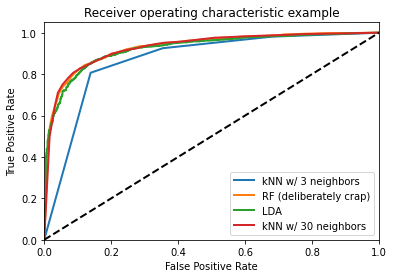

In [22]:
y_score_knn = knn.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)

y_score_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)

y_score_lda = lda.predict_proba(X_test)[:,1]
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_score_lda)

y_score_knn2 = knn2.predict_proba(X_test)[:,1]
fpr_knn2, tpr_knn2, _ = roc_curve(y_test, y_score_knn2)

plt.figure()
lw = 2
plt.plot(fpr_knn, tpr_knn, color='C0', lw=lw, label='kNN w/ 3 neighbors')
plt.plot(fpr_rf, tpr_rf, color='C1', lw=lw, label='RF (deliberately crap)')
plt.plot(fpr_lda, tpr_lda, color='C2', lw=lw, label='LDA')
plt.plot(fpr_knn2, tpr_knn2, color='C3', lw=lw, label='kNN w/ 30 neighbors')

plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

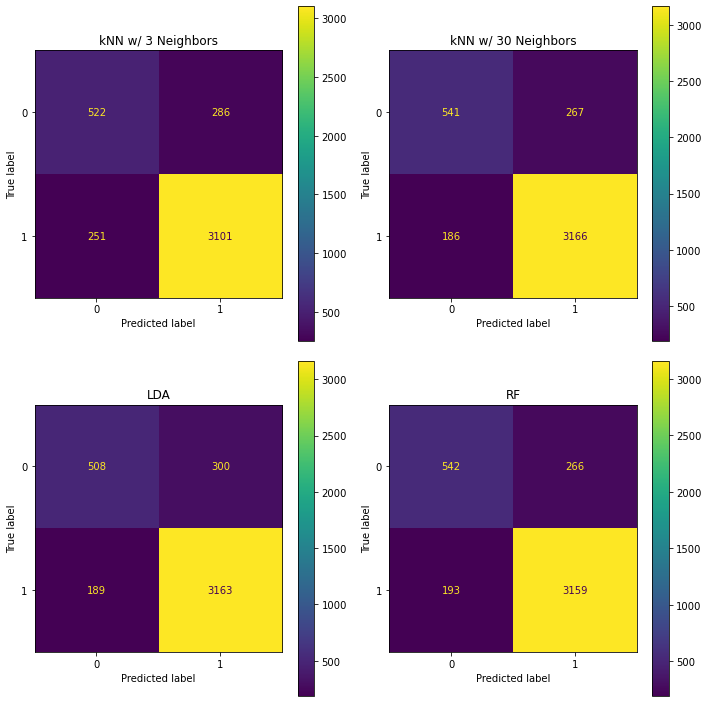

In [23]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

plot_confusion_matrix(knn, X_test, y_test, ax=axs[0][0])
ax = axs[0][0]
ax.set_title('kNN w/ 3 Neighbors')

plot_confusion_matrix(knn2, X_test, y_test, ax=axs[0][1])
ax = axs[0][1]
ax.set_title('kNN w/ 30 Neighbors')

plot_confusion_matrix(lda, X_test, y_test, ax=axs[1][0])
ax = axs[1][0]
ax.set_title('LDA')

plot_confusion_matrix(rf, X_test, y_test, ax=axs[1][1])
ax = axs[1][1]
ax.set_title('RF');

fig.tight_layout()

In [24]:
print('kNN w/ 3 neighbors\n', classification_report(y_test, knn.predict(X_test)))

print('kNN w/ 30 neighbors\n', classification_report(y_test, knn2.predict(X_test)))

print('LDA', classification_report(y_test, lda.predict(X_test)))

print('Deliberately Crap RF', classification_report(y_test, rf.predict(X_test)))

kNN w/ 3 neighbors
               precision    recall  f1-score   support

           0       0.68      0.65      0.66       808
           1       0.92      0.93      0.92      3352

    accuracy                           0.87      4160
   macro avg       0.80      0.79      0.79      4160
weighted avg       0.87      0.87      0.87      4160

kNN w/ 30 neighbors
               precision    recall  f1-score   support

           0       0.74      0.67      0.70       808
           1       0.92      0.94      0.93      3352

    accuracy                           0.89      4160
   macro avg       0.83      0.81      0.82      4160
weighted avg       0.89      0.89      0.89      4160

LDA               precision    recall  f1-score   support

           0       0.73      0.63      0.68       808
           1       0.91      0.94      0.93      3352

    accuracy                           0.88      4160
   macro avg       0.82      0.79      0.80      4160
weighted avg       0.88      